Required Packages: 
- pandas
- numpy
- matplotlib (pyplot from it)
- scikiet-learn
- wbgapi (world bank data api)

Main
conda install -y pandas numpy matplotlib scikit-learn jupyterlab

World bank API client
pip install wbgapi

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import wbgapi as wb
import shap
print(os.getcwd())

#importing rawdata
rawdata_path = "data/rawdata.csv"
rawdata = pd.read_csv(rawdata_path)

/Users/mnn/miniforge3/envs/ds-shap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/mnn/Documents/ME/Professional Porfolios/Data Analytics Portfolio/AIxSustainability


In [3]:
# Inspecting Raw Data
# Number of rows (country-year observations) and columns (variables)
n_rows = rawdata.shape[0]
n_cols = rawdata.shape[1]
print("Number of rows:", n_rows)
print("Number of columns:", n_cols)

# How many unique countries (by iso_code)
n_countries = rawdata['iso_code'].nunique()
print("Unique countries (iso_code):", n_countries)

# How many unique years
n_years = rawdata['year'].nunique()
print("Unique years:", n_years)

# Minimum and maximum year in the data
min_year = rawdata['year'].min()
max_year = rawdata['year'].max()
print("Year range:", min_year, "to", max_year)

# A row is a duplicate if the same iso_code and year appear more than once
n_dupes = rawdata.duplicated(subset=['iso_code', 'year']).sum()
print("Number of duplicate iso_code-year rows:", n_dupes)

Number of rows: 7129
Number of columns: 15
Unique countries (iso_code): 204
Unique years: 35
Year range: 1990 to 2024
Number of duplicate iso_code-year rows: 0


In [4]:
# Missingness summary table function to check

def missingness_overall(df):
    total_rows = len(df)

    summary = pd.DataFrame({
        "n_non_missing": df.notna().sum(),
        "n_missing": df.isna().sum(),
    })

    summary["pct_non_missing"] = (summary["n_non_missing"] / total_rows * 100).round(1)
    summary["pct_missing"] = (summary["n_missing"] / total_rows * 100).round(1)

    summary = summary.sort_values("pct_non_missing", ascending=False)

    return summary

display(missingness_overall(rawdata))

,n_non_missing,n_missing,pct_non_missing,pct_missing
year,7129,0,100.0,0.0
iso_code,7129,0,100.0,0.0
country,7129,0,100.0,0.0
gni_pc,6852,277,96.1,3.9
urban_population_pct,6755,374,94.8,5.2
population_growth_pct,6752,377,94.7,5.3
co2,6707,422,94.1,5.9
co2_per_capita,6707,422,94.1,5.9
co2_growth_prct,6694,435,93.9,6.1
life_expectancy,6562,567,92.0,8.0


In [5]:
# Simple missingness summary for each column

# For each column, count how many values are missing (NaN)
n_missing = rawdata.isna().sum()

# For each column, count how many values are NOT missing
n_non_missing = n_rows - n_missing

# Calculate percentage of non-missing values for each column
pct_non_missing = (n_non_missing / n_rows) * 100

# Combine everything into one small summary table (DataFrame)
missing_summary = pd.DataFrame({
    'n_non_missing': n_non_missing,
    'n_missing': n_missing,
    'pct_non_missing': pct_non_missing.round(1)  # rounded to 1 decimal
})

# Sort so that columns with most data (highest pct_non_missing) come first
missing_summary = missing_summary.sort_values('pct_non_missing', ascending=False)

# Show the summary
missing_summary

,n_non_missing,n_missing,pct_non_missing
year,7129,0,100.0
iso_code,7129,0,100.0
country,7129,0,100.0
gni_pc,6852,277,96.1
urban_population_pct,6755,374,94.8
population_growth_pct,6752,377,94.7
co2,6707,422,94.1
co2_per_capita,6707,422,94.1
co2_growth_prct,6694,435,93.9
life_expectancy,6562,567,92.0


Everything except consumption_co2 has >80% coverage.
Core variable (gni_pc, urban/ population growth, CO₂, life expectancy, under5, mys) are all ~90–96%.

In [6]:

coverage_rows = []  # this will store one small row per year

for year, df_year in rawdata.groupby('year'):
    # df_year = all rows for this specific year
    
    n_rows_year = df_year.shape[0]              # how many country-rows in this year
    n_missing = df_year.isna().sum()            # missing count per column for this year
    n_non_missing = n_rows_year - n_missing     # non-missing count per column
    pct_non_missing = (n_non_missing / n_rows_year * 100).round(1)  # % non-missing
    
    # turn this into a one-row DataFrame, index = year
    row = pct_non_missing.to_frame().T
    row.index = [year]
    
    coverage_rows.append(row)

# Combine all years into a single DataFrame
coverage_by_year_explicit = pd.concat(coverage_rows).sort_index()

coverage_by_year_explicit

,year,iso_code,co2,co2_growth_prct,co2_per_capita,consumption_co2,electricity_access_pct,renewable_energy_pct,under5_mortality,life_expectancy,population_growth_pct,urban_population_pct,mys,gni_pc,country
1990,100.0,100.0,91.7,89.7,91.7,57.8,37.3,89.2,93.6,94.6,94.1,94.6,79.9,95.6,100.0
1991,100.0,100.0,92.2,91.7,92.2,57.8,42.6,89.7,93.6,94.6,94.1,94.6,79.9,95.6,100.0
1992,100.0,100.0,93.1,92.2,93.1,57.8,49.5,91.7,93.6,94.6,94.6,94.6,79.9,95.6,100.0
1993,100.0,100.0,93.1,93.1,93.1,57.8,53.9,91.7,93.6,94.6,94.6,94.6,79.9,96.1,100.0
1994,100.0,100.0,94.1,93.1,94.1,57.8,56.9,91.7,93.6,94.6,94.6,94.6,79.9,96.1,100.0
1995,100.0,100.0,94.1,93.6,94.1,57.8,60.3,92.2,93.6,94.6,94.6,94.6,81.9,98.0,100.0
1996,100.0,100.0,94.1,93.6,94.1,57.8,64.7,92.2,93.6,94.6,94.6,94.6,81.9,98.0,100.0
1997,100.0,100.0,94.1,93.6,94.1,57.8,67.6,92.2,93.6,94.6,94.6,94.6,81.9,98.0,100.0
1998,100.0,100.0,94.1,93.6,94.1,57.8,70.6,92.2,93.6,94.6,94.6,94.6,81.9,98.0,100.0
1999,100.0,100.0,94.1,94.1,94.1,57.8,73.5,92.2,93.6,94.6,94.6,94.6,83.3,98.0,100.0


### Data coverage by year: summary and modelling decision

Coverage by year was calculated as the percentage of non-missing observations for each variable in each year (1990–2024). The `coverage_by_year` table reports these values.

**Main patterns**

- `iso_code`, `country` and `year` are complete (100% coverage in all years).
- Core socio-economic and demographic indicators (`gni_pc`, `mys`, `life_expectancy`, `under5_mortality`, `urban_population_pct`, `population_growth_pct`) show high coverage, typically around 90–100% throughout the period.
- CO₂-related variables (`co2`, `co2_per_capita`, `co2_growth_prct`) also display consistently high coverage (~90–95%+).
- `electricity_access_pct` has lower coverage in the early 1990s (≈37–70%) but stabilises above ~90% from around 2000 onwards.
- `renewable_energy_pct` is generally well-covered up to 2021 but coverage drops strongly in the most recent years.
- `consumption_co2` is systematically the weakest variable, with coverage around 56–58% in most years.

**Recent years**

- In 2022, most indicators remain well-covered, but `renewable_energy_pct` coverage decreases.
- In 2023, `renewable_energy_pct` has 0% coverage, while other variables remain high.
- In 2024, CO₂ and population-related variables are almost fully covered, but several human development and access indicators (`mys`, `gni_pc`, `life_expectancy`, `under5_mortality`, `electricity_access_pct`, `renewable_energy_pct`) are missing entirely, indicating that 2024 data are not yet fully populated.

**Modelling window**

Given these patterns:

- Years **1995–2021** form a stable core period with consistently high coverage across key indicators.
- Years **2022–2024** are better treated as supplementary for descriptive or exploratory analysis, due to incomplete coverage for multiple variables.
- `consumption_co2` is weak and on top of that Consumption-based CO₂ is not included as a predictor, as it represents an alternative emissions accounting metric rather than an independent driver of territorial emissions per capita.
- So focus is on all variables except `consumption_co2`for year 1995 to 2021.

In [7]:
# Keep only years 1995–2021
analysis_data = rawdata[(rawdata['year'] >= 1995) & (rawdata['year'] <= 2021)].copy()

# Drop consumption-based CO2 (not the focus, low coverage)
analysis_data = analysis_data.drop(columns=['consumption_co2'])

# Quick check
print("Shape of analysis_data:", analysis_data.shape)
print("Year range:", analysis_data['year'].min(), "to", analysis_data['year'].max())
print("Columns:")
analysis_data.columns

Shape of analysis_data: (5508, 14)
Year range: 1995 to 2021
Columns:


Index(['year', 'iso_code', 'co2', 'co2_growth_prct', 'co2_per_capita',
       'electricity_access_pct', 'renewable_energy_pct', 'under5_mortality',
       'life_expectancy', 'population_growth_pct', 'urban_population_pct',
       'mys', 'gni_pc', 'country'],
      dtype='object')

In [8]:
# Describe variables 
id_cols = ['iso_code', 'country', 'year']

# Main outcome of interest
target_col = 'co2_per_capita'

# Optional / secondary outcomes (can be used for robustness or descriptive analysis)
secondary_target_cols = ['co2', 'co2_growth_prct']

# Predictor (feature) candidates: human development and structural factors
feature_cols = [
    'gni_pc',
    'mys',
    'life_expectancy',
    'under5_mortality',
    'electricity_access_pct',
    'renewable_energy_pct',
    'urban_population_pct',
    'population_growth_pct',
]

# Combine into a single ordered list of columns
ordered_cols = id_cols + [target_col] + secondary_target_cols + feature_cols

# Reorder the DataFrame
analysis_data = analysis_data[ordered_cols].copy()

analysis_data.head()

,iso_code,country,year,co2_per_capita,co2,co2_growth_prct,gni_pc,mys,life_expectancy,under5_mortality,electricity_access_pct,renewable_energy_pct,urban_population_pct,population_growth_pct
5,AFG,Afghanistan,1995,0.083,1.417,-2.511,2034.991008,1.088489,52.103,152.8,NaN,31.8,17.834385,4.893680
6,AFG,Afghanistan,1996,0.077,1.370,-3.332,1852.207871,1.123602,52.830,148.3,NaN,33.9,17.959649,4.005405
7,AFG,Afghanistan,1997,0.071,1.304,-4.814,1690.905132,1.158715,53.212,144.1,NaN,36.4,18.092857,3.804508
8,AFG,Afghanistan,1998,0.067,1.279,-1.967,1554.303960,1.193827,52.487,139.9,NaN,38.0,18.235814,3.764687
9,AFG,Afghanistan,1999,0.055,1.092,-14.616,1425.314494,1.228940,54.532,135.8,NaN,43.4,18.390327,3.728116


In [9]:
# Make a small dataset with only target + features
model_cols = [target_col] + feature_cols
model_data = analysis_data[model_cols].copy()

# Reuse the missingness_overall function on this smaller dataset
missing_model = missingness_overall(model_data)
print(missing_model)

# How many rows have no missing values in any model column?

# Total number of rows in this subset
n_rows_model = model_data.shape[0]

# Number of rows with no missing values at all
n_complete_rows = model_data.dropna().shape[0]

print("Rows with complete data for target + all features:", n_complete_rows)
print("Total rows in analysis_data:", n_rows_model)
print("Share complete (%):", round(n_complete_rows / n_rows_model * 100, 1))


                        n_non_missing  n_missing  pct_non_missing  pct_missing
gni_pc                           5467         41             99.3          0.7
mys                              5232        276             95.0          5.0
urban_population_pct             5211        297             94.6          5.4
life_expectancy                  5211        297             94.6          5.4
population_growth_pct            5211        297             94.6          5.4
co2_per_capita                   5184        324             94.1          5.9
under5_mortality                 5157        351             93.6          6.4
renewable_energy_pct             5145        363             93.4          6.6
electricity_access_pct           4917        591             89.3         10.7
Rows with complete data for target + all features: 4636
Total rows in analysis_data: 5508
Share complete (%): 84.2


### Handling missing data in the modelling variables

Missing values in the main outcome (`co2_per_capita`) and the selected predictor variables were addressed in two stages, using only data from the 1995–2021 analysis window.

1. **Time-based interpolation within countries**

   - The dataset was first sorted by `iso_code` and `year`.
   - For each country, linear interpolation over time was applied to `co2_per_capita` and all selected predictor variables.
   - This fills gaps where a country has values in surrounding years (for example, a missing value between two observed years), while preserving country-specific trends over time.

   After this step, several variables (such as `gni_pc` and part of `mys` and `electricity_access_pct`) no longer contained missing values, but some gaps remained for indicators with sparse reporting in certain countries and years.

2. **Removal of remaining incomplete rows**

   - After interpolation, any remaining rows with missing values in the modelling variables (`co2_per_capita` and all selected predictors) were removed.
   - This reduced the analysis sample from 5,508 to 5,103 country–year observations, implying the removal of 405 rows that still had incomplete information.
   - The resulting modelling dataset contains no missing values in the outcome or predictor variables.

This approach combines simple, transparent interpolation with a conservative complete-case filter, ensuring that the final modelling dataset is internally consistent and free of missing values in the variables entering the regression models.


In [10]:
# Expand model_data to include id columns and model columns (target + features)
# This just ensures model_data has iso_code and year for groupby, plus the cols we want to interpolate.

model_data = analysis_data[id_cols + model_cols].copy()

# Sort by country and year so interpolation follows time within each country
model_data = model_data.sort_values(['iso_code', 'year'])

# Interpolate missing values within each country, over time
# Using transform instead of apply so the index stays aligned with model_data
model_data[model_cols] = (
    model_data
    .groupby('iso_code')[model_cols]
    .transform(lambda s: s.interpolate(method='linear', limit_direction='both'))
)

# Check remaining missing values after interpolation
print("Missing values after interpolation:")
print(model_data[model_cols].isna().sum())

# Drop remaining rows with missing values in target + features, after interpolation
before_rows = model_data.shape[0]
print("Rows before dropping remaining missing:", before_rows)

# Keep only rows where all model columns are non-missing
model_data = model_data.dropna(subset=model_cols).copy()

after_rows = model_data.shape[0]
print("Rows after dropping remaining missing:", after_rows)
print("Rows removed:", before_rows - after_rows)

# Final check: should all be zero now
print("\nMissing values in model columns after drop:")
print(model_data[model_cols].isna().sum())


Missing values after interpolation:
co2_per_capita            324
gni_pc                      0
mys                        27
life_expectancy           297
under5_mortality          351
electricity_access_pct    297
renewable_energy_pct      324
urban_population_pct      297
population_growth_pct     297
dtype: int64
Rows before dropping remaining missing: 5508
Rows after dropping remaining missing: 5103
Rows removed: 405

Missing values in model columns after drop:
co2_per_capita            0
gni_pc                    0
mys                       0
life_expectancy           0
under5_mortality          0
electricity_access_pct    0
renewable_energy_pct      0
urban_population_pct      0
population_growth_pct     0
dtype: int64


In [11]:
model_data.describe()

,year,co2_per_capita,gni_pc,mys,life_expectancy,under5_mortality,electricity_access_pct,renewable_energy_pct,urban_population_pct,population_growth_pct
count,5103.000000,5103.000000,5103.000000,5103.000000,5103.000000,5103.000000,5103.000000,5103.000000,5103.000000,5103.000000
mean,2008.000000,4.626878,19164.971398,7.905642,68.964692,42.521693,77.166770,32.846600,55.612532,1.417357
std,7.789644,6.490564,21213.730404,3.277984,9.164883,46.807191,31.488815,29.808416,22.902411,1.634656
min,1995.000000,0.000000,507.875627,0.724238,14.665000,2.200000,0.800000,0.000000,7.168294,-17.988214
25%,2001.000000,0.628500,4113.781299,5.375599,63.324000,9.800000,57.050000,6.500000,35.906769,0.414902
50%,2008.000000,2.302000,11221.792140,8.134000,70.810244,22.900000,96.900000,23.900000,56.406815,1.336396
75%,2015.000000,6.370000,26278.526340,10.650000,75.676000,59.850000,100.000000,55.250000,73.831384,2.344440
max,2021.000000,76.715000,127692.416900,14.296372,84.560000,478.900000,100.000000,98.300000,100.000000,21.700343


### Distributions and skewness of key variables

Descriptive statistics for the 1995–2021 modelling sample indicate that several variables are noticeably skewed:

- **CO₂ emissions per capita (`co2_per_capita`)**
  - Mean ≈ 4.63, median ≈ 2.30, with a maximum of 76.7.
  - The mean being substantially higher than the median, combined with a very large maximum relative to the upper quartile (75th percentile ≈ 6.37), indicates a strong right-skew: most country–year observations have relatively low emissions per capita, while a smaller group of high-emitting observations sits in the upper tail.

- **Gross national income per capita (`gni_pc`)**
  - Median ≈ 11,200, mean ≈ 19,165 and maximum ≈ 127,700.
  - The wide range and the large gap between the median and maximum reflect the familiar pattern of a small number of high-income economies and a large number of lower- and middle-income countries. This creates a highly right-skewed distribution.

- **Under-five mortality (`under5_mortality`)**
  - Values range from about 2.2 to nearly 479 deaths per 1,000 live births.
  - The median (≈ 22.9) and the high maximum again point to a distribution where most observations are relatively low, but a subset of country–years with very high child mortality rates forms a long right tail.

- **Percentage variables (`electricity_access_pct`, `renewable_energy_pct`, `urban_population_pct`)**
  - These indicators are bounded between 0 and 100. Their quartiles and means suggest more moderate skewness, although there are clear differences between low-access / low-urbanisation contexts and highly electrified or urbanised countries.

- **Population growth (%) (`population_growth_pct`)**
  - The distribution is centred around small positive values (median ≈ 1.34), but exhibits some extreme negative and positive outliers (minimum ≈ -18.0, maximum ≈ 21.7), reflecting episodes of sharp demographic change.

Skewness of this kind has two main implications for modelling:

1. **Influence of extreme values**  
   Strong right tails in variables such as `gni_pc`, `co2_per_capita` and `under5_mortality` mean that a relatively small number of observations can have a disproportionate influence on parameter estimates in linear regression, especially when using ordinary least squares.

2. **Approximate linearity and interpretability**  
   Many relationships between income, emissions, health and demographic indicators are closer to log-linear than strictly linear in levels. Applying simple log-transformations to heavily skewed variables (using log(1 + x)) helps compress the upper tails, reduces the influence of extreme values, and can make the relationship between predictors and the outcome more linear on the transformed scale.

For these reasons, log-transformed versions of `gni_pc`, `co2_per_capita` and `under5_mortality` are constructed and used alongside the original variables in the subsequent exploratory analysis and modelling.


In [12]:
# Add simple log-transformed versions of highly skewed variables

# Log of gross national income per capita
model_data['gni_pc_log'] = np.log1p(model_data['gni_pc'])

# Log of CO₂ emissions per capita (main outcome)
model_data['co2_per_capita_log'] = np.log1p(model_data['co2_per_capita'])

# Log of under-five mortality
model_data['under5_mortality_log'] = np.log1p(model_data['under5_mortality'])

# Quick check
model_data[['gni_pc', 'gni_pc_log', 'co2_per_capita', 'co2_per_capita_log', 
            'under5_mortality', 'under5_mortality_log']].head()

,gni_pc,gni_pc_log,co2_per_capita,co2_per_capita_log,under5_mortality,under5_mortality_log
5,2034.991008,7.618738,0.083,0.079735,152.8,5.035653
6,1852.207871,7.524673,0.077,0.074179,148.3,5.005958
7,1690.905132,7.433610,0.071,0.068593,144.1,4.977423
8,1554.303960,7.349426,0.067,0.064851,139.9,4.948050
9,1425.314494,7.262849,0.055,0.053541,135.8,4.918520


In [13]:
# Correlation matrix for logged target and predictors

# Columns to include in the correlation analysis
eda_cols = [
    'co2_per_capita_log',   # logged outcome
    'gni_pc_log',           # logged income
    'mys',
    'life_expectancy',
    'under5_mortality_log', # logged mortality
    'electricity_access_pct',
    'renewable_energy_pct',
    'urban_population_pct',
    'population_growth_pct',
]

# Compute the correlation matrix
corr_matrix = model_data[eda_cols].corr()

# Display the numeric matrix (optional)
corr_matrix

,co2_per_capita_log,gni_pc_log,mys,life_expectancy,under5_mortality_log,electricity_access_pct,renewable_energy_pct,urban_population_pct,population_growth_pct
co2_per_capita_log,1.000000,0.887663,0.715683,0.703686,-0.763548,0.723606,-0.734107,0.720636,-0.218911
gni_pc_log,0.887663,1.000000,0.765742,0.829418,-0.872602,0.796375,-0.686327,0.756070,-0.283584
mys,0.715683,0.765742,1.000000,0.727160,-0.820485,0.760564,-0.619028,0.592014,-0.465060
life_expectancy,0.703686,0.829418,0.727160,1.000000,-0.928895,0.836467,-0.650520,0.648821,-0.327454
under5_mortality_log,-0.763548,-0.872602,-0.820485,-0.928895,1.000000,-0.799620,0.635407,-0.665189,0.414250
electricity_access_pct,0.723606,0.796375,0.760564,0.836467,-0.799620,1.000000,-0.774079,0.663359,-0.419160
renewable_energy_pct,-0.734107,-0.686327,-0.619028,-0.650520,0.635407,-0.774079,1.000000,-0.555949,0.293281
urban_population_pct,0.720636,0.756070,0.592014,0.648821,-0.665189,0.663359,-0.555949,1.000000,-0.184620
population_growth_pct,-0.218911,-0.283584,-0.465060,-0.327454,0.414250,-0.419160,0.293281,-0.184620,1.000000


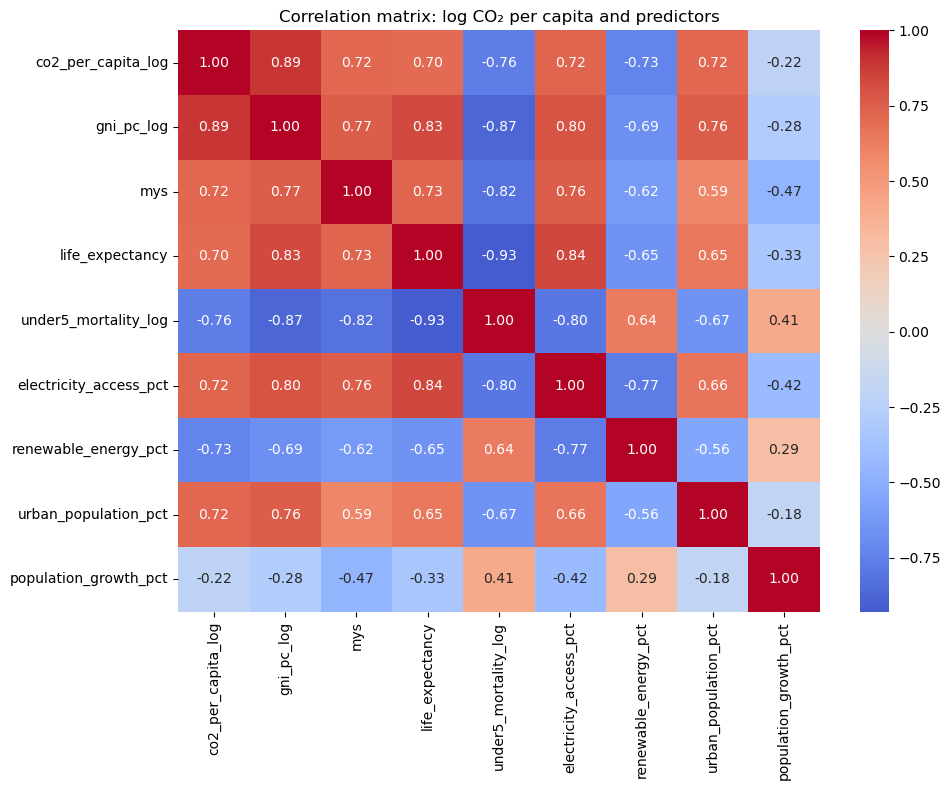

In [14]:
# Visualise the correlation matrix as a heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,           # show numbers in the cells
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation matrix: log CO₂ per capita and predictors")
plt.tight_layout()
plt.show()

### Correlations between log CO₂ emissions per capita and predictors

The correlation matrix for the log-transformed outcome (`co2_per_capita_log`) and key predictors shows several clear patterns:

**Association with income and development**

- `co2_per_capita_log` is strongly positively correlated with `gni_pc_log` (≈ 0.89), indicating that higher-income country–years tend to have higher territorial CO₂ emissions per capita.
- Positive correlations are also observed with `mys` (≈ 0.72) and `life_expectancy` (≈ 0.70), and a strong negative correlation with `under5_mortality_log` (≈ −0.76). These patterns are consistent with higher emissions per capita being associated with higher levels of human development.

**Access, urbanisation, and energy mix**

- `co2_per_capita_log` is positively correlated with `electricity_access_pct` (≈ 0.72) and `urban_population_pct` (≈ 0.72), suggesting that more electrified and more urbanised societies tend to have higher emissions per capita.
- In contrast, `co2_per_capita_log` is negatively correlated with `renewable_energy_pct` (≈ −0.73), implying that a greater share of renewables in final energy consumption is associated with lower territorial CO₂ emissions per capita.

**Demographic dynamics**

- `population_growth_pct` shows a relatively weak negative correlation with `co2_per_capita_log` (≈ −0.22), but a moderate positive correlation with `under5_mortality_log` (≈ 0.41) and negative correlations with development indicators. This reflects that faster population growth is more common in lower-income, lower-development contexts, which often have lower emissions per capita.

**Correlations among predictors**

- Development-related predictors are highly correlated with one another: `gni_pc_log`, `mys`, `life_expectancy`, `under5_mortality_log`, `electricity_access_pct` and `urban_population_pct` form a tightly connected group with correlations often above |0.75|.
- This strong correlation structure implies a high degree of multicollinearity among the predictors. As a result, individual regression coefficients may be difficult to interpret in isolation, and model evaluation should focus on overall fit and predictive performance rather than the precise magnitude of single coefficients.

Overall, the correlation structure is consistent with a pattern where higher human development and infrastructure access are associated with higher CO₂ emissions per capita, while a higher share of renewables is associated with lower per-capita emissions.


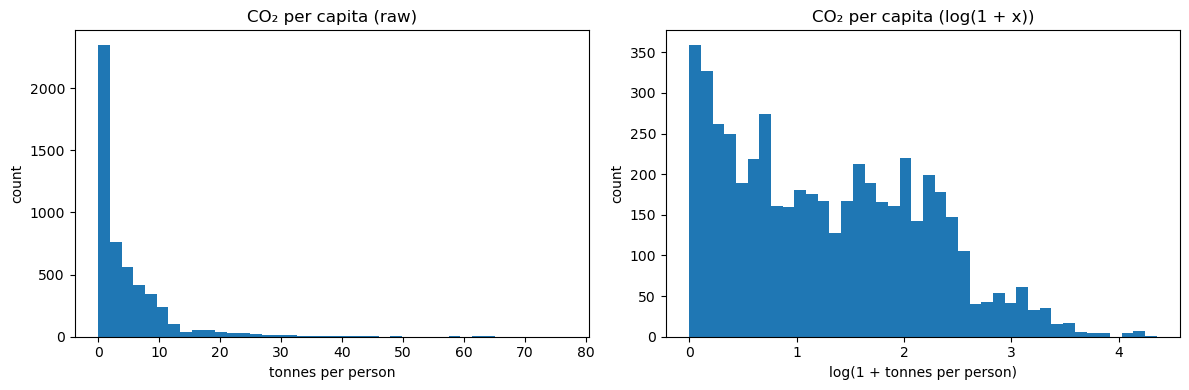

In [15]:
#Distribution of CO₂ per capita (raw and log)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Raw CO2 per capita
plt.subplot(1, 2, 1)
plt.hist(model_data['co2_per_capita'], bins=40)
plt.title("CO₂ per capita (raw)")
plt.xlabel("tonnes per person")
plt.ylabel("count")

# Log CO2 per capita
plt.subplot(1, 2, 2)
plt.hist(model_data['co2_per_capita_log'], bins=40)
plt.title("CO₂ per capita (log(1 + x))")
plt.xlabel("log(1 + tonnes per person)")
plt.ylabel("count")

plt.tight_layout()
plt.show()

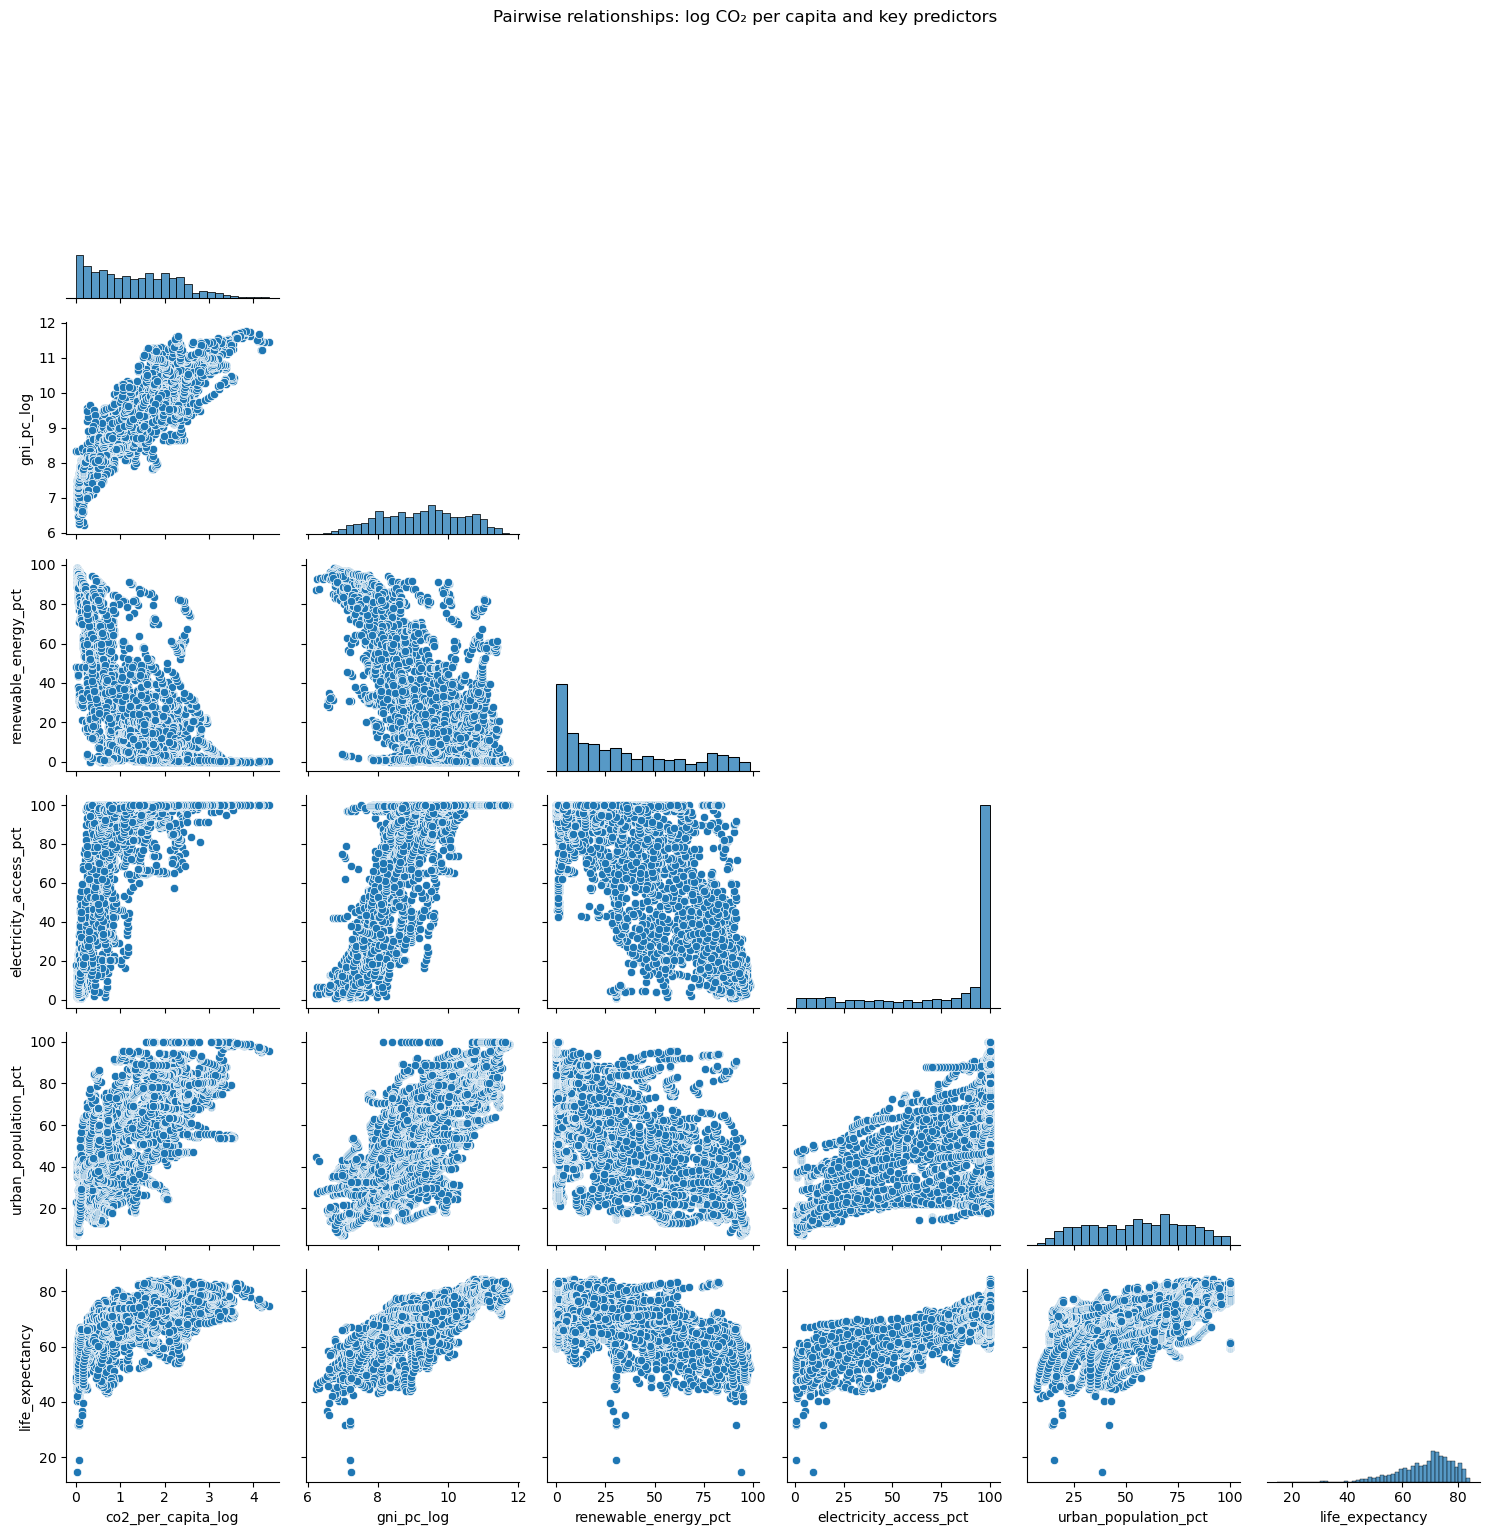

In [16]:
# Composite EDA plot (pairplot) for key variables

pairplot_cols = [
    'co2_per_capita_log',
    'gni_pc_log',
    'renewable_energy_pct',
    'electricity_access_pct',
    'urban_population_pct',
    'life_expectancy'
]

sns.pairplot(
    data=model_data[pairplot_cols],
    corner=True,      # only plot the lower triangle to keep it cleaner
    diag_kind='hist'  # histograms on the diagonal
)

plt.suptitle("Pairwise relationships: log CO₂ per capita and key predictors", y=1.02)
plt.tight_layout()
plt.show()

### Exploratory data analysis: main patterns

The histogram of CO₂ emissions per capita in levels is highly right-skewed: most country–year observations lie at low emission levels, with a long upper tail formed by a smaller set of high-emitting cases. After applying the log(1 + x) transformation, the distribution of `co2_per_capita_log` becomes much more symmetric and spreads information more evenly across the range of emission levels, which is more suitable for linear regression.

The pairplot for `co2_per_capita_log` and key predictors confirms the correlation results:

- There is a clear positive relationship between log CO₂ emissions per capita and log income per capita (`gni_pc_log`), with higher-income observations clustered at higher emission levels.
- Higher electricity access, higher urban population shares and higher life expectancy are all associated with higher log CO₂ emissions per capita, reflecting a broad development and infrastructure gradient.
- The share of renewables in final energy consumption (`renewable_energy_pct`) shows a visible negative relationship with log CO₂ emissions per capita: country–years with a larger renewable share tend to have lower emissions per person.
- Scatterplots among the development indicators themselves (income, life expectancy, electricity access, urbanisation) show tight positive relationships, indicating strong multicollinearity and a common underlying development dimension.

Overall, the EDA supports using `co2_per_capita_log` as the main outcome and treating income, human development, access to electricity, urbanisation and the energy mix as key predictors in the subsequent regression models.


In [17]:
model_data.columns


Index(['iso_code', 'country', 'year', 'co2_per_capita', 'gni_pc', 'mys',
       'life_expectancy', 'under5_mortality', 'electricity_access_pct',
       'renewable_energy_pct', 'urban_population_pct', 'population_growth_pct',
       'gni_pc_log', 'co2_per_capita_log', 'under5_mortality_log'],
      dtype='object')

In [18]:
from sklearn.model_selection import train_test_split

# Define which columns are features (X) and which is the target (y)

y_col = 'co2_per_capita_log'

X_cols = [
    'gni_pc_log',
    'mys',
    'life_expectancy',
    'under5_mortality_log',
    'electricity_access_pct',
    'renewable_energy_pct',
    'urban_population_pct',
    'population_growth_pct',
]

# Time-based split: train on 1995–2012, test on 2013–2021

split_year = 2012

train_mask = model_data['year'] <= split_year
test_mask  = model_data['year'] > split_year

X_train = model_data.loc[train_mask, X_cols]
y_train = model_data.loc[train_mask, y_col]

X_test = model_data.loc[test_mask, X_cols]
y_test = model_data.loc[test_mask, y_col]

print("Train period years:", model_data.loc[train_mask, 'year'].min(), "to", model_data.loc[train_mask, 'year'].max())
print("Test period years:", model_data.loc[test_mask, 'year'].min(), "to", model_data.loc[test_mask, 'year'].max())
print("Train size:", X_train.shape[0], "rows")
print("Test size:", X_test.shape[0], "rows")


Train period years: 1995 to 2012
Test period years: 2013 to 2021
Train size: 3402 rows
Test size: 1701 rows


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Build a simple pipeline: standardise features -> linear regression

lin_model = make_pipeline(
    StandardScaler(),     # puts features on similar scale
    LinearRegression()
)

# Fit model on training data
lin_model.fit(X_train, y_train)

# Predictions
y_pred_train = lin_model.predict(X_train)
y_pred_test  = lin_model.predict(X_test)

# STEP 4: Compute R² and MSE for train and test

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

results = pd.DataFrame({
    "dataset": ["train", "test"],
    "R2": [
        r2_score(y_train, y_pred_train),
        r2_score(y_test, y_pred_test),
    ],
    "MSE": [
        mse(y_train, y_pred_train),
        mse(y_test, y_pred_test),
    ]
})

print(results)

  dataset        R2       MSE
0   train  0.852986  0.126263
1    test  0.793500  0.151105


In [20]:
from sklearn.ensemble import RandomForestRegressor
# Fit a Random Forest regressor
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf  = rf_model.predict(X_test)

# Helper for MSE
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

# Collect performance for linear model and RF in one table
# If lin_model, y_pred_train, y_pred_test still exist from before, this will work directly.
results_compare = pd.DataFrame({
    "model": ["LinearRegression", "RandomForest"],
    "dataset": ["test", "test"],
    "R2": [
        r2_score(y_test, y_pred_test),      # linear model (from before)
        r2_score(y_test, y_pred_test_rf),   # random forest
    ],
    "MSE": [
        mse(y_test, y_pred_test),
        mse(y_test, y_pred_test_rf),
    ]
})

print(results_compare)

              model dataset        R2       MSE
0  LinearRegression    test  0.793500  0.151105
1      RandomForest    test  0.888405  0.081659


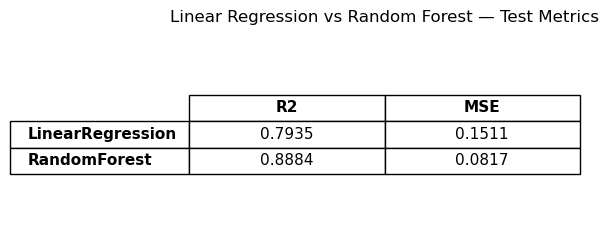

In [21]:
# Filter to test set only
cmp = results_compare[results_compare["dataset"] == "test"].copy()
cmp = cmp.set_index("model")

# Round for display
cmp_display = cmp[["R2", "MSE"]].round(4)

fig, ax = plt.subplots(figsize=(6, 2.5))
ax.axis("off")

table = ax.table(
    cellText=cmp_display.values,
    rowLabels=cmp_display.index,
    colLabels=cmp_display.columns,
    loc="center",
    cellLoc="center"
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.6)

# Bold headers
for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight="bold")

plt.title(
    "Linear Regression vs Random Forest — Test Metrics",
    pad=12
)

plt.tight_layout()
plt.show()

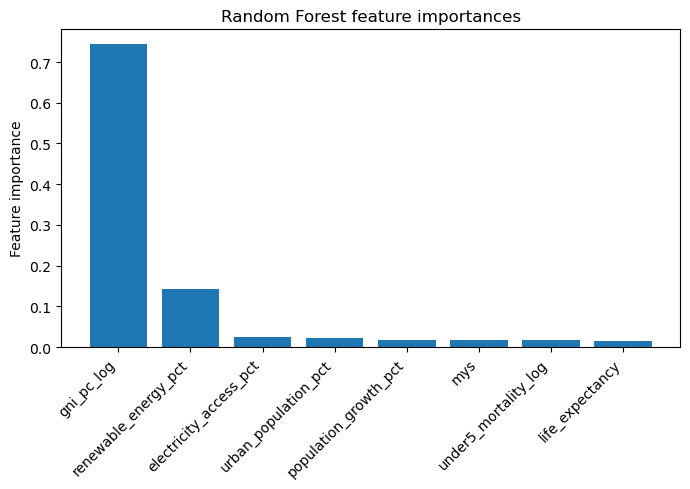

In [22]:
# Plotting RF feature importances

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # sort descending

plt.figure(figsize=(7, 5))
plt.bar(range(len(X_cols)), importances[indices])
plt.xticks(range(len(X_cols)), [X_cols[i] for i in indices], rotation=45, ha='right')
plt.ylabel("Feature importance")
plt.title("Random Forest feature importances")
plt.tight_layout()
plt.show()

In [23]:
# SHAP explainability for the Random Forest

# Create a small sample of the training data for speed
X_train_sample = X_train.sample(n=min(1000, X_train.shape[0]), random_state=42)

# Build the explainer
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the sample
shap_values = explainer.shap_values(X_train_sample)

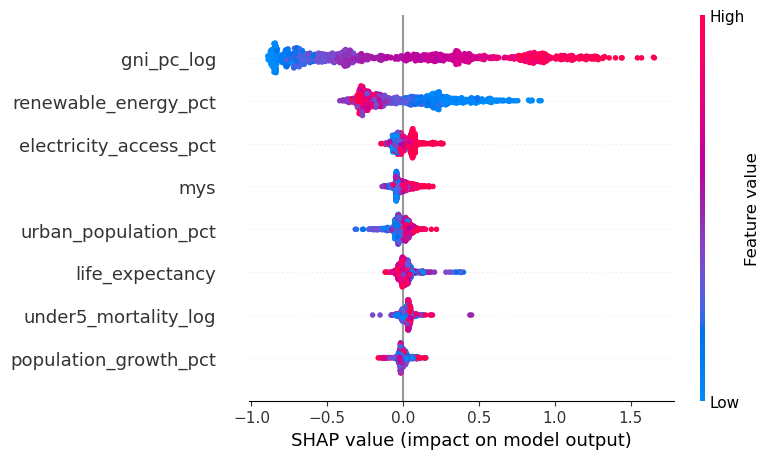

In [24]:

# SHAP summary plot (importance + direction)
shap.summary_plot(
    shap_values,
    X_train_sample,
    feature_names=X_cols,
    show=True
)

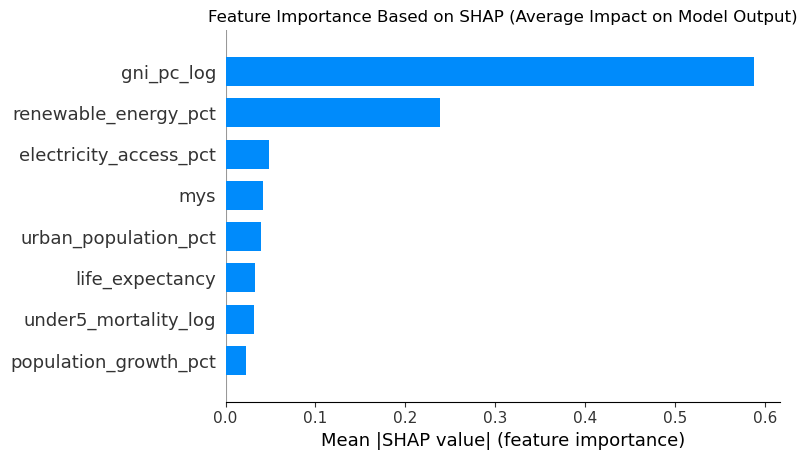

In [32]:
shap.summary_plot(
    shap_values,
    X_train_sample,
    feature_names=X_cols,
    plot_type="bar",
    show=False,
)

plt.xlabel("Mean |SHAP value| (feature importance)")
plt.title("Feature Importance Based on SHAP (Average Impact on Model Output)")

plt.tight_layout()
plt.show()

plt.show()

### Model comparison and feature importance (Random Forest vs SHAP)

The Random Forest model substantially improves predictive performance relative to the baseline linear regression:

| model            | dataset | R²    | MSE    |
|------------------|---------|-------|--------|
| LinearRegression | test    | 0.794 | 0.151  |
| RandomForest     | test    | 0.888 | 0.082  |

The non-linear Random Forest explains close to 89% of the variance in log CO₂ emissions per capita in the test period, compared with about 79% for the linear model.

#### Tree-based feature importance (mean decrease in impurity)

The standard `feature_importances_` output from the Random Forest is based on **mean decrease in impurity** (MDI):

- Each split in a tree reduces the training error (impurity) by some amount.
- For a given feature, these reductions are summed over all splits where the feature is used, across all trees.
- The totals are normalised to sum to 1, giving a **global importance score** per feature.

In this model:

- `gni_pc_log` dominates the MDI importance, followed by `renewable_energy_pct`.
- Other predictors (`electricity_access_pct`, `urban_population_pct`, `population_growth_pct`, `mys`, `under5_mortality_log`, `life_expectancy`) contribute much smaller shares.

While MDI importances are easy to compute and interpret as “how much this feature helps to reduce error in the trees”, they have limitations:

- They only provide **global importance** (no information about individual predictions).
- They do not show **direction** (whether high values increase or decrease predicted emissions).
- They can be biased towards features with higher variance or many effective split points, and they are affected by correlations among predictors.

#### SHAP values: local, additive explanations

SHAP (SHapley Additive exPlanations) provides a more detailed view of how features influence the model’s predictions:

- SHAP values are based on the idea of **Shapley values** from cooperative game theory.  
  For each observation and feature, a SHAP value measures the **marginal contribution** of that feature to the prediction, averaged over all possible combinations of other features.
- For tree-based models, `TreeExplainer` computes SHAP values efficiently and exactly (up to numerical precision).
- SHAP values are **local** (one set per observation) but can be aggregated to obtain **global importance** measures.

In this analysis:

- The SHAP **beeswarm plot** shows, for each feature (rows), the distribution of SHAP values across all observations (points):
  - The horizontal position (x-axis) is the SHAP value: how much that feature pushes the prediction of log CO₂ per capita up (positive) or down (negative) for a given observation.
  - The colour encodes the feature value (red = high, blue = low).
- For `gni_pc_log`, high values (red points) cluster on the **right-hand side**, indicating that higher income strongly increases predicted CO₂ emissions per capita. Low income (blue points) pulls predictions down.
- For `renewable_energy_pct`, the pattern is reversed: higher renewable shares tend to have negative SHAP values (pushing emissions down), while low renewable shares are associated with positive contributions to emissions.
- `electricity_access_pct`, `urban_population_pct`, `mys` and `life_expectancy` show more moderate but still consistent patterns, where higher development and access levels generally increase predicted emissions.
- `under5_mortality_log` and `population_growth_pct` have smaller average SHAP magnitudes, indicating weaker overall influence in this specification.

The SHAP **bar plot** summarises these local effects by plotting the **mean absolute SHAP value** for each feature. This provides a global ranking of importance that is conceptually different from MDI:

- MDI importance measures how much a feature helps to reduce training error inside the trees.
- Mean |SHAP| importance measures how large the feature’s contribution is to the model’s predictions **on average across all observations**.

In this model, both MDI and SHAP-based global importance rankings agree that:

- `gni_pc_log` is by far the most influential predictor.
- `renewable_energy_pct` is the second most important feature.
- Other predictors have smaller, but still non-negligible, contributions.

SHAP therefore complements the standard tree-based importances by:

- providing **local, observation-specific explanations**,
- revealing the **direction and non-linearity** of each feature’s effect,
- and offering a more robust global importance measure based on the magnitude of actual contributions to model outputs rather than only on how often a feature is used in splits.


In [26]:
# Save the final modelling dataset
model_data.to_csv("data/model_data_clean.csv", index=False)

In [27]:
indicator_metadata = pd.DataFrame([
    {
        "indicator_id": "co2_per_capita",
        "name": "CO₂ emissions per capita",
        "description": (
            "Territorial CO₂ emissions divided by total population, expressed in tonnes per person. "
            "Captures average emissions responsibility per person within a country in a given year."
        )
    },
    {
        "indicator_id": "gni_pc",
        "name": "Gross national income per capita (PPP)",
        "description": (
            "Gross national income per person, adjusted for purchasing power parity (PPP). "
            "Includes domestic production and net foreign income, and is a core measure of average material living standards."
        )
    },
    {
        "indicator_id": "mys",
        "name": "Mean years of schooling (adults 25+)",
        "description": (
            "Average number of completed years of formal education among the population aged 25 years and older. "
            "Used as an educational attainment component in human development measures."
        )
    },
    {
        "indicator_id": "life_expectancy",
        "name": "Life expectancy at birth",
        "description": (
            "Average number of years a newborn is expected to live, assuming current age-specific mortality rates "
            "remain constant throughout their life. Summarises overall mortality conditions and population health."
        )
    },
    {
        "indicator_id": "under5_mortality",
        "name": "Under-five mortality rate",
        "description": (
            "Probability of dying between birth and age five, expressed per 1,000 live births. "
            "Reflects child health, access to basic services and broader social and environmental conditions."
        )
    },
    {
        "indicator_id": "electricity_access_pct",
        "name": "Access to electricity (% of population)",
        "description": (
            "Share of the population with access to electricity from any source. "
            "Indicates basic infrastructure availability and is closely linked to living standards and productive capacity."
        )
    },
    {
        "indicator_id": "renewable_energy_pct",
        "name": "Renewable energy share in final energy use",
        "description": (
            "Share of renewables in total final energy consumption, including sources such as hydro, wind, solar and modern bioenergy. "
            "Provides a simple measure of how carbon-intensive or low-carbon the energy mix is."
        )
    },
    {
        "indicator_id": "urban_population_pct",
        "name": "Urban population (% of total)",
        "description": (
            "Share of the total population living in urban areas. "
            "Captures the degree of urbanisation, which influences energy demand, infrastructure, transport patterns and exposure to environmental risks."
        )
    },
    {
        "indicator_id": "population_growth_pct",
        "name": "Population growth rate (%)",
        "description": (
            "Annual percentage change in the resident population. "
            "Reflects underlying demographic dynamics and can amplify or dampen aggregate pressures on resources and emissions."
        )
    },
])

indicator_metadata

,indicator_id,name,description
0,co2_per_capita,CO₂ emissions per capita,Territorial CO₂ emissions divided by total pop...
1,gni_pc,Gross national income per capita (PPP),"Gross national income per person, adjusted for..."
2,mys,Mean years of schooling (adults 25+),Average number of completed years of formal ed...
3,life_expectancy,Life expectancy at birth,Average number of years a newborn is expected ...
4,under5_mortality,Under-five mortality rate,Probability of dying between birth and age fiv...
5,electricity_access_pct,Access to electricity (% of population),Share of the population with access to electri...
6,renewable_energy_pct,Renewable energy share in final energy use,Share of renewables in total final energy cons...
7,urban_population_pct,Urban population (% of total),Share of the total population living in urban ...
8,population_growth_pct,Population growth rate (%),Annual percentage change in the resident popul...
